## Introduction

To explore overfitting, we'll use a dataset on cars which contains 7 numerical features that could have an effect on a car's fuel efficiency:

* cylinders -- the number of cylinders in the engine.
* displacement -- the displacement of the engine.
* horsepower -- the horsepower of the engine.
* weight -- the weight of the car.
* acceleration -- the acceleration of the car.
* model year -- the year that car model was released (e.g. 70 corresponds to 1970).
* origin -- where the car was manufactured (0 if North America, 1 if Europe, 2 if Asia).

The mpg column is our target column and is the one we want to predict using the other features.

In [19]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

In [3]:
columns = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model year", "origin", "car name"]
cars = pd.read_table("auto-mpg.data", delim_whitespace=True, names=columns)
filtered_cars = cars[cars['horsepower'] != '?'].copy()
filtered_cars['horsepower'] = filtered_cars['horsepower'].astype('float')

In [7]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [8]:
filtered_cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    float64
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car name      392 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 30.6+ KB


## Bias and Variance

At the heart of understanding overfitting is understanding **bias** and <b>variance</b>. **Bias** and **variance** make up the 2 observable sources of error in a model that we can indirectly control.

Bias describes error that results in bad assumptions about the learning algorithm. For example, assuming that only one feature, like a car's weight, relates to a car's fuel efficiency will lead you to fit a simple, univariate regression model that will result in high bias. The error rate will be high since a car's fuel efficiency is affected by many other factors besides just its weight.

Variance describes error that occurs because of the variability of a model's predicted values. If we were given a dataset with 1000 features on each car and used every single feature to train an incredibly complicated multivariate regression model, we will have low bias but high variance.

In an ideal world, we want low bias and low variance but in reality, there's always a tradeoff.

## Bias-variance tradeoff

![Jupyter](./bias-variance-tradeoff.png)

![Jupyter](./bias-and-variance.png)

In [12]:
filtered_cars['weight'].var()

721484.7090075159

In [14]:
def train_and_test(cols):
    x = filtered_cars[cols]
    y = filtered_cars['mpg']
    
    lr = LinearRegression()
    lr.fit(x, y)
    preds = lr.predict(x)
    
    mse = mean_squared_error(y, preds)
    variance = preds.var()
    
    return(mse, variance)

In [15]:
cyl_mse, cyl_var = train_and_test(['cylinders'])
weight_mse, weight_var = train_and_test(['weight'])

print(cyl_mse, cyl_var)
print(weight_mse, weight_var)

24.02017956815553 36.742558874160174
18.6766165974193 42.08612184489639


## Multivariate models

In [17]:
one_mse, one_var = train_and_test(["cylinders"])

two_mse, two_var = train_and_test(["cylinders", "displacement"])

three_mse, three_var = train_and_test(["cylinders", "displacement", "horsepower"])

four_mse, four_var = train_and_test(["cylinders", "displacement", "horsepower", "weight"])

five_mse, five_var = train_and_test(["cylinders", "displacement", "horsepower", "weight", "acceleration"])

six_mse, six_var = train_and_test(["cylinders", "displacement", "horsepower", "weight", "acceleration", "model year"])

seven_mse, seven_var = train_and_test(["cylinders", "displacement", "horsepower", "weight", "acceleration", "model year", "origin"])

In [18]:
print(one_mse, one_var)
print(two_mse, two_var)
print(three_mse, three_var)
print(four_mse, four_var)
print(five_mse, five_var)
print(six_mse, six_var)
print(seven_mse, seven_var)

24.02017956815553 36.742558874160174
21.282057055586364 39.4806813867294
20.25295483971423 40.50978360260138
17.763860571843846 42.99887787047188
17.761396105406217 43.00134233690938
11.590170981415229 49.17256746090048
10.847480945000449 49.91525749731511


## Cross validation

The multivariate regression models you trained got progressively better at reducing the amount of error.

A good way to detect if your model is overfitting is to compare the <b>in-sample error</b> and the **out-of-sample error**, or the training error with the test error. So far, we calculated the in sample error by testing the model over the same data it was trained on. To calculate the out-of-sample error, we need to test the data on a test set of data. We unfortunately don't have a separate test dataset and we'll instead use cross validation.

If a model's cross validation error (out-of-sample error) is much higher than the in sample error, then your data science senses should start to tingle. This is the first line of defense against overfitting and is a clear indicator that the trained model doesn't generalize well outside of the training set.

In [34]:
def train_and_cross_val(cols): 
    lr = LinearRegression()
    kf = KFold(n_splits=10, shuffle=True, random_state=3)
    X = filtered_cars[cols]
    y = filtered_cars['mpg']
    mses = []
    variance_values = []
    
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
        y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]
        lr.fit(X_train, y_train)
        preds = lr.predict(X_test)
        mses.append(mean_squared_error(y_test, preds))
        variance_values.append(preds.var())    
    return(np.mean(mses), np.mean(variance_values))

In [35]:
two_mse, two_var = train_and_cross_val(['cylinders', 'displacement'])

three_mse, three_var = train_and_cross_val(["cylinders", "displacement", "horsepower"])

four_mse, four_var = train_and_cross_val(["cylinders", "displacement", "horsepower", "weight"])

five_mse, five_var = train_and_cross_val(["cylinders", "displacement", "horsepower", "weight", "acceleration"])

six_mse, six_var = train_and_cross_val(["cylinders", "displacement", "horsepower", "weight", "acceleration", "model year"])

seven_mse, seven_var = train_and_cross_val(["cylinders", "displacement", "horsepower", "weight", "acceleration", "model year", "origin"])

In [36]:
print(one_mse, one_var)
print(two_mse, two_var)
print(three_mse, three_var)
print(four_mse, four_var)
print(five_mse, five_var)
print(six_mse, six_var)
print(seven_mse, seven_var)

24.02017956815553 36.742558874160174
21.584370274954377 38.90252531375603
20.655622193882955 40.091287956606955
18.169683239081888 42.50764364364437
18.283038517172052 42.59873630014682
12.099685425467126 48.92824696771807
11.418131971812064 49.90431373098731


## Plotting cross-validation error vs. cross-validation variance

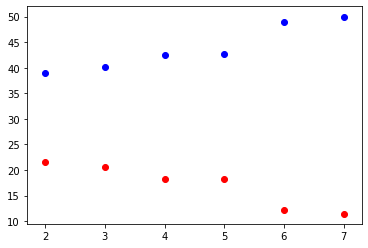

In [37]:
x = range(2,8)
y1 = [two_mse, three_mse, four_mse, five_mse, six_mse, seven_mse]
y2 = [two_var, three_var, four_var, five_var, six_var, seven_var]

plt.scatter(x, y1, c='red')
plt.scatter(x, y2, c='blue')
plt.show()

## Conclusion

While the higher order multivariate models overfit in relation to the lower order multivariate models, the in-sample error and out-of-sample didn't deviate by much. The best model was around **50%** more accurate than the simplest model. On the other hand, the overall variance increased around **25%** as we increased the model complexity. This is a really good starting point, but your work is not done! The increased variance with the increased model complexity means that your model will have more unpredictable performance on truly new, unseen data.

If you were working on this problem on a data science team, you'd need to confirm the predictive accuracy of the model using completely new, unobserved data (e.g. maybe from cars from later years). Since often you can't wait until a model is deployed in the wild to know how well it works, the exploration we did in this mission helps you approximate a model's real world performance.